In [1]:
#Meir's Notebook

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from statsmodels.formula.api import ols
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
%matplotlib inline

In [87]:
# Reading in the data set into varialbe housing_df and changing the 2nd column into datetime
housing_df = pd.read_csv('./data/kc_house_data.csv', parse_dates=[1])

In [4]:
# Looking at the dataframe to see the overall data organization 
pd.set_option('display.max_columns', None)
housing_df.head()
# Decided to keep id column for future reference, in case of new data addition, as well as checking for duplicates. 

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
# Checking data type of each column
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  float64       
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     19221 non-null  object        
 9   view           21534 non-null  object        
 10  condition      21597 non-null  object        
 11  grade          21597 non-null  object        
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21597 non-null  object        
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   1775

In [6]:
# Checking to see if any columns have NaN values
housing_df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [7]:
((housing_df.view.isna().sum())/(len(housing_df.view))) * 100

0.29170718155299347

In [8]:
((housing_df.yr_renovated.isna().sum())/((len(housing_df.yr_renovated)))) * 100

17.78950780200954

In [9]:
ren_col = housing_df[['yr_renovated']]
imputer = SimpleImputer(strategy='constant', fill_value = 0)
imputer.fit(ren_col)
ren_imputed = imputer.transform(ren_col)
housing_df.yr_renovated = ren_imputed

In [10]:
((housing_df.waterfront.isna().sum())/(len(housing_df.waterfront))) * 100

11.00152798999861

In [11]:

#Deal with duplicated `id`
#Add `resold_id` column, where first occurrence = 0 and later occurrences = 1

In [12]:
housing_df['grade'] = housing_df['grade'].str[0:2].str.strip().astype(int)

In [13]:
#dict_replace = {'Poor': 1, 'Fair': 2, 'Average': 3, 'Good': 4, 'Very Good': 5}
#housing_df['condition'] = housing_df['condition'].replace(dict_replace)

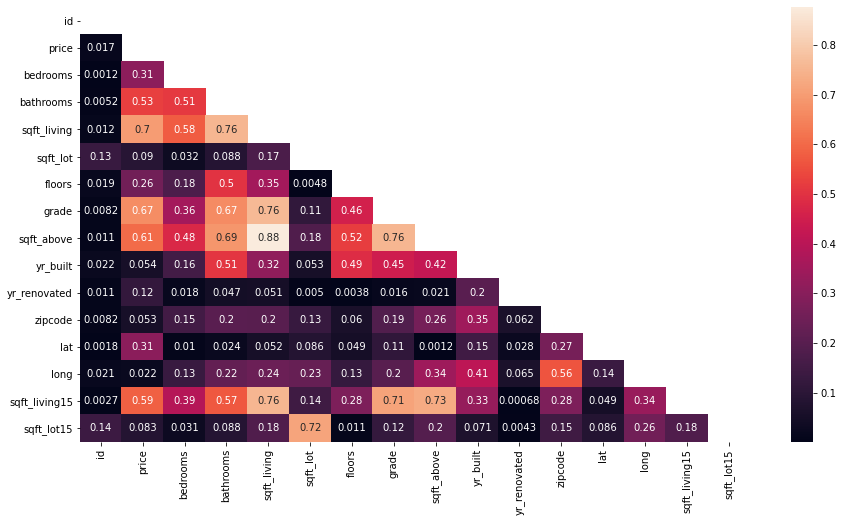

In [14]:
corr = abs(housing_df.corr())
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corr, mask=np.triu(np.ones_like(corr, dtype=bool)), annot=True);

# We can see that sqft_above is collinear with sqft_living. 
# That's why we can replace sqft_above with boolean for new column 'basement'
# We also see collinearity between sqft_living and grade. square footage is numeric and continuous,
# easier to use than grade. We can drop grade.

In [15]:
# Age of home when sold
housing_df['year_sold'] = housing_df['date'].dt.year
housing_df['age_when_sold'] = housing_df['year_sold'] - housing_df['yr_built']

In [16]:
housing_df['sqft_basement'] = housing_df['sqft_living'] - housing_df['sqft_above']
housing_df['basement'] = housing_df['sqft_basement'].map(lambda x: True if x > 0 else False)
housing_df['basement'] = housing_df['basement'].astype(int)

In [17]:
housing_df_clean = housing_df.drop(['date', 'grade','sqft_basement','sqft_above','yr_built', 'year_sold', 'yr_renovated', 'lat', 'long'], axis=1)
housing_df_clean

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,zipcode,sqft_living15,sqft_lot15,age_when_sold,basement
0,7129300520,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,98178,1340,5650,59,0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,98125,1690,7639,63,1
2,5631500400,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,98028,2720,8062,82,0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,98136,1360,5000,49,1
4,1954400510,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,98074,1800,7503,28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,360000.0,3,2.50,1530,1131,3.0,NO,NONE,Average,98103,1530,1509,5,0
21593,6600060120,400000.0,4,2.50,2310,5813,2.0,NO,NONE,Average,98146,1830,7200,1,0
21594,1523300141,402101.0,2,0.75,1020,1350,2.0,NO,NONE,Average,98144,1020,2007,5,0
21595,291310100,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,Average,98027,1410,1287,11,0


In [18]:
#corr = abs(housing_df_clean.corr())
#fig, ax = plt.subplots(figsize=(15, 8))
#sns.heatmap(corr, mask=np.triu(np.ones_like(corr, dtype=bool)), annot=True);

In [19]:
numerical_df = housing_df_clean[['price','bedrooms','bathrooms', 'sqft_living', 'floors', 'sqft_living15']]

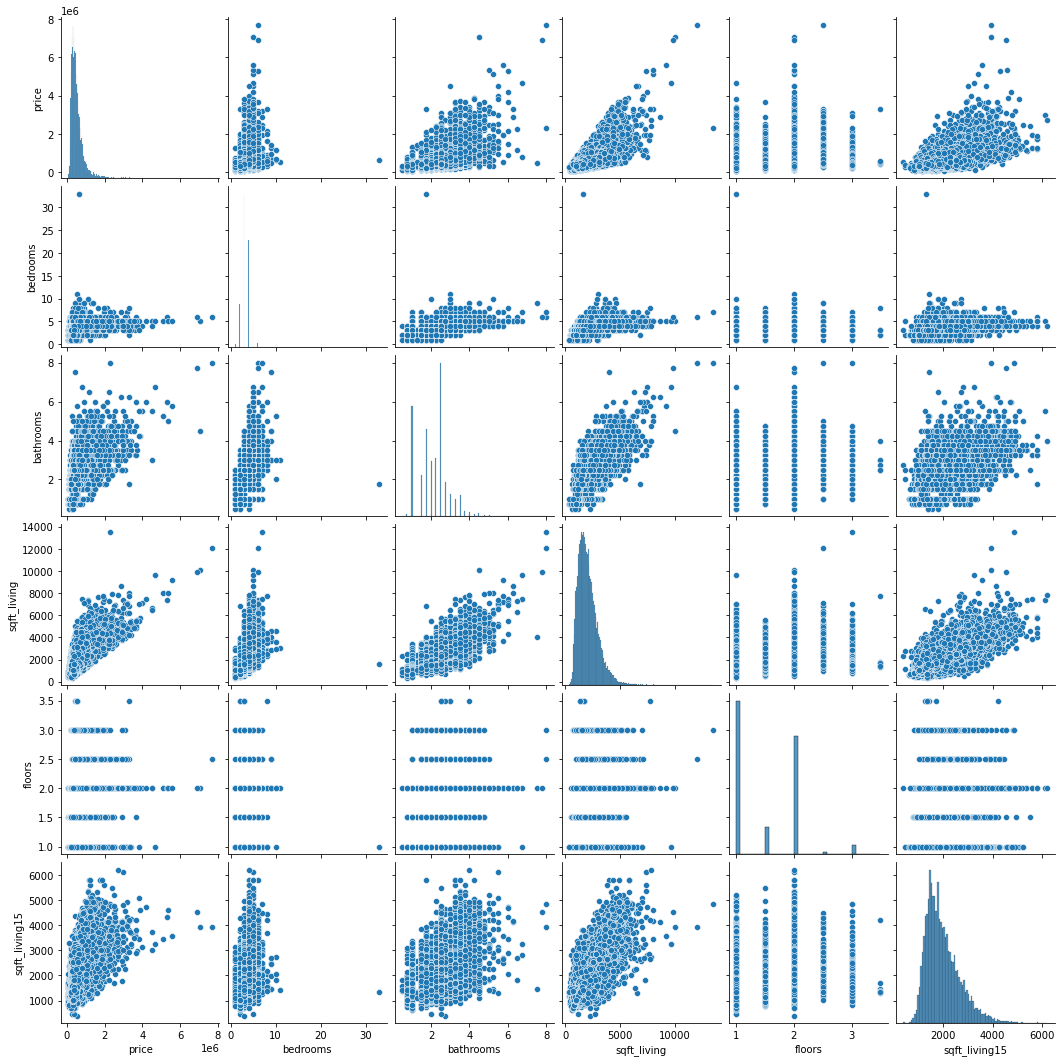

In [20]:
sns.pairplot(numerical_df)

In [21]:
# Creating a new column that takes the log of price
# housing_df_clean['price'] = np.log(housing_df_clean['price'])

In [22]:
X = housing_df_clean.drop(columns = 'price', axis=1)
y = housing_df_clean['price']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [24]:
view_col = X_train[['view']]
imputer_view = SimpleImputer(strategy='constant', fill_value = 'NONE')
imputer_view.fit(view_col)
view_imputed = imputer_view.transform(view_col)
X_train.view = view_imputed

/Users/meiralelov/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [25]:
view_col = X_test[['view']]
view_imputed = imputer_view.transform(view_col)
X_test.view = view_imputed

/Users/meiralelov/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [26]:
water_col = X_train[['waterfront']]
imputer_water = SimpleImputer(strategy='constant', fill_value = 'NO')
imputer_water.fit(water_col)
waterfront_imputed = imputer_water.transform(water_col)
X_train.waterfront = waterfront_imputed

/Users/meiralelov/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [27]:
water_col = X_test[['waterfront']]
waterfront_test_imputed = imputer_water.transform(water_col)
X_test.waterfront = waterfront_test_imputed

/Users/meiralelov/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [28]:
water_col = X_train[['waterfront']]
encoder_water = OrdinalEncoder()
encoder_water.fit(water_col)
encoded_water = encoder_water.transform(water_col)
encoded_water = encoded_water.flatten()
X_train.waterfront = encoded_water

/Users/meiralelov/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [29]:
water_col = X_test[['waterfront']]
encoded_water = encoder_water.transform(water_col)
encoded_water = encoded_water.flatten()
X_test.waterfront = encoded_water

/Users/meiralelov/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [42]:
cat_cols = [c for c in housing_df_clean.columns if housing_df_clean[c].dtype == 'O']
cat_cols = [ 'view', 'condition', 'floors', 'zipcode']
cat_cols

['view', 'condition', 'floors', 'zipcode']

In [43]:
X_train.isna().sum()

id               0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
zipcode          0
sqft_living15    0
sqft_lot15       0
age_when_sold    0
basement         0
dtype: int64

In [44]:
# create an encoder object. This will help us to convert
# categorical variables to new columns
encoder = OneHotEncoder(handle_unknown='error',
                        drop='first',
                        categories='auto')

# Create an columntransformer object.
# This will help us to merge transformed columns
# with the rest of the dataset.

ct = ColumnTransformer(transformers=[('ohe', encoder, cat_cols)],
                       remainder='passthrough')
ct.fit(X_train)
X_train_enc = ct.transform(X_train)
X_test_enc = ct.transform(X_test)

In [45]:
X_train_enc = pd.DataFrame(X_train_enc.todense(), columns= ct.get_feature_names())
X_train_enc.head()

,ohe__x0_EXCELLENT,ohe__x0_FAIR,ohe__x0_GOOD,ohe__x0_NONE,ohe__x1_Fair,ohe__x1_Good,ohe__x1_Poor,ohe__x1_Very Good,ohe__x2_1.5,ohe__x2_2.0,ohe__x2_2.5,ohe__x2_3.0,ohe__x2_3.5,ohe__x3_98002,ohe__x3_98003,ohe__x3_98004,ohe__x3_98005,ohe__x3_98006,ohe__x3_98007,ohe__x3_98008,ohe__x3_98010,ohe__x3_98011,ohe__x3_98014,ohe__x3_98019,ohe__x3_98022,ohe__x3_98023,ohe__x3_98024,ohe__x3_98027,ohe__x3_98028,ohe__x3_98029,ohe__x3_98030,ohe__x3_98031,ohe__x3_98032,ohe__x3_98033,ohe__x3_98034,ohe__x3_98038,ohe__x3_98039,ohe__x3_98040,ohe__x3_98042,ohe__x3_98045,ohe__x3_98052,ohe__x3_98053,ohe__x3_98055,ohe__x3_98056,ohe__x3_98058,ohe__x3_98059,ohe__x3_98065,ohe__x3_98070,ohe__x3_98072,ohe__x3_98074,ohe__x3_98075,ohe__x3_98077,ohe__x3_98092,ohe__x3_98102,ohe__x3_98103,ohe__x3_98105,ohe__x3_98106,ohe__x3_98107,ohe__x3_98108,ohe__x3_98109,ohe__x3_98112,ohe__x3_98115,ohe__x3_98116,ohe__x3_98117,ohe__x3_98118,ohe__x3_98119,ohe__x3_98122,ohe__x3_98125,ohe__x3_98126,ohe__x3_98133,ohe__x3_98136,ohe__x3_98144,ohe__x3_98146,ohe__x3_98148,ohe__x3_98155,ohe__x3_98166,ohe__x3_98168,ohe__x3_98177,ohe__x3_98178,ohe__x3_98188,ohe__x3_98198,ohe__x3_98199,id,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,sqft_living15,sqft_lot15,age_when_sold,basement
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.083306e+09,5.0,3.75,3330.0,5042.0,0.0,1780.0,3990.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.022059e+09,3.0,2.00,1678.0,13862.0,0.0,1550.0,11753.0,21.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.623039e+09,4.0,1.00,1550.0,15239.0,1.0,1790.0,22047.0,84.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.923600e+09,3.0,2.50,2760.0,9471.0,0.0,3040.0,6765.0,58.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.511600e+09,2.0,1.50,1400.0,5810.0,0.0,1470.0,3920.0,75.0,0.0


In [46]:
X_test_enc = pd.DataFrame(X_test_enc.todense(), columns= ct.get_feature_names())
X_test_enc.head()

,ohe__x0_EXCELLENT,ohe__x0_FAIR,ohe__x0_GOOD,ohe__x0_NONE,ohe__x1_Fair,ohe__x1_Good,ohe__x1_Poor,ohe__x1_Very Good,ohe__x2_1.5,ohe__x2_2.0,ohe__x2_2.5,ohe__x2_3.0,ohe__x2_3.5,ohe__x3_98002,ohe__x3_98003,ohe__x3_98004,ohe__x3_98005,ohe__x3_98006,ohe__x3_98007,ohe__x3_98008,ohe__x3_98010,ohe__x3_98011,ohe__x3_98014,ohe__x3_98019,ohe__x3_98022,ohe__x3_98023,ohe__x3_98024,ohe__x3_98027,ohe__x3_98028,ohe__x3_98029,ohe__x3_98030,ohe__x3_98031,ohe__x3_98032,ohe__x3_98033,ohe__x3_98034,ohe__x3_98038,ohe__x3_98039,ohe__x3_98040,ohe__x3_98042,ohe__x3_98045,ohe__x3_98052,ohe__x3_98053,ohe__x3_98055,ohe__x3_98056,ohe__x3_98058,ohe__x3_98059,ohe__x3_98065,ohe__x3_98070,ohe__x3_98072,ohe__x3_98074,ohe__x3_98075,ohe__x3_98077,ohe__x3_98092,ohe__x3_98102,ohe__x3_98103,ohe__x3_98105,ohe__x3_98106,ohe__x3_98107,ohe__x3_98108,ohe__x3_98109,ohe__x3_98112,ohe__x3_98115,ohe__x3_98116,ohe__x3_98117,ohe__x3_98118,ohe__x3_98119,ohe__x3_98122,ohe__x3_98125,ohe__x3_98126,ohe__x3_98133,ohe__x3_98136,ohe__x3_98144,ohe__x3_98146,ohe__x3_98148,ohe__x3_98155,ohe__x3_98166,ohe__x3_98168,ohe__x3_98177,ohe__x3_98178,ohe__x3_98188,ohe__x3_98198,ohe__x3_98199,id,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,sqft_living15,sqft_lot15,age_when_sold,basement
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.303401e+09,3.0,0.75,850.0,8573.0,0.0,850.0,8382.0,70.0,1.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.995200e+09,3.0,1.00,1510.0,6083.0,0.0,1510.0,5712.0,74.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.423089e+09,4.0,2.25,1790.0,42000.0,0.0,2060.0,50094.0,32.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.349900e+09,2.0,1.50,1140.0,2500.0,0.0,1500.0,5000.0,27.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.550004e+08,3.0,1.00,1500.0,3920.0,0.0,1640.0,4017.0,67.0,1.0


In [47]:
# intstantiate our scaler
scaler = StandardScaler()

# train on train data
scaler.fit(X_train_enc)

# transform both train and test data
X_train_scaled = scaler.transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

In [48]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns= ct.get_feature_names())

In [49]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns= ct.get_feature_names())

In [50]:
# first simple model

col_use = ['sqft_living']
fsm_model = LinearRegression()
fsm_model.fit(X_train_scaled[col_use], y_train)
print(fsm_model.score(X_train_scaled[col_use], y_train))
print(fsm_model.score(X_test_scaled[col_use], y_test))

0.4920581575642742
0.4939471244478427


In [59]:
fsm_model.coef_[0]

259657.38203930086

In [58]:
fsm_model.intercept_

542085.8330223236

In [57]:
# Setting up our dummy regressor
dummy_regr = DummyRegressor()
dummy_regr.fit(X_train, y_train)
print(dummy_regr.score(X_train, y_train))

0.0


In [62]:
train_preds = fsm_model.predict(X_train_scaled[col_use])
test_preds = fsm_model.predict(X_test_scaled[col_use])

In [66]:
train_resids = y_train - train_preds
test_resids = y_test - test_preds

In [64]:
r2_score(y_train, train_preds)

0.4920581575642742

In [65]:
r2_score(y_test, test_preds)

0.4939471244478427

In [52]:
#look at assumptions and errors after every model 

In [80]:
bins = int(  len(X_test_scaled[col_use])**.5 )

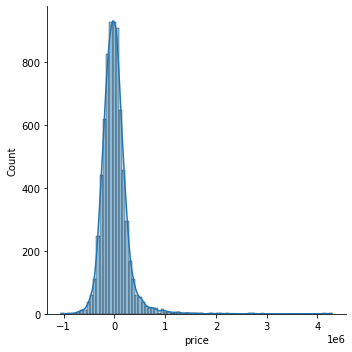

In [81]:
sns.displot(test_resids, bins=bins, kde=True);

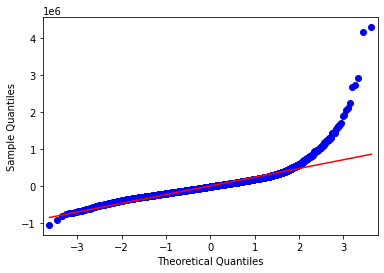

In [82]:
sm.qqplot(test_resids, line='r');

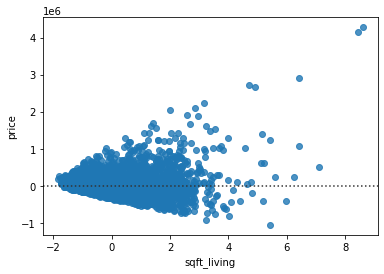

In [84]:
sns.residplot(x=X_test_scaled[col_use], y=y_test);

In [89]:
print('\nPerforming Durbin-Watson Test')
print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
print('0 to 2< is positive autocorrelation')
print('>2 to 4 is negative autocorrelation')
print('-------------------------------------')

durbinWatson = durbin_watson(test_resids)

print('Durbin-Watson:', durbinWatson)

if durbinWatson < 1.5:
    print('Signs of positive autocorrelation', '\n')
    print('Assumption not satisfied')
elif durbinWatson > 2.5:
    print('Signs of negative autocorrelation', '\n')
    print('Assumption not satisfied')
else:
    print('Little to no autocorrelation', '\n')
    print('Assumption satisfied')


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.0236601963441303
Little to no autocorrelation 

Assumption satisfied
